In [1]:
import pandas as pd
import pyterrier as pt
# read csvs without header, column names are qid, sep, uuid, score
if not pt.started():
    pt.init()
qrels = pt.io.read_qrels("../data/assessments/qrels.txt") # type: ignore
qcred = pt.io.read_qrels("../data/assessments/qcredibility.txt") # type: ignore
qread = pt.io.read_qrels("../data/assessments/qreadability.txt") # type: ignore


PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [2]:
qrels.head()

,qid,docno,label
0,1,a6195d99-f7d7-43ec-907c-435cb7a62ee7,2
1,1,80fd9af1-c9b6-4d82-b62a-fe16d5b9d76f,1
2,1,4a8c5d85-b2d0-43bc-83f4-c1acfe0b3481,2
3,1,22990a4b-6a9f-4e00-9e72-aef0fbee202b,0
4,1,fd6ddab2-e4d9-4151-9972-256f5be6eb21,1


In [3]:
import xml.etree.ElementTree as ET
import pandas as pd

def load_topics(path, clean_query=False):
    with open(path) as f:
        root = ET.fromstring(f.read())
    topic_dict = {}
    for topic in root.findall("topic"):
        topic_id = topic.findtext("id")
        topic_query = topic.findtext("query")
        if topic_id and topic_query:
            topic_dict[topic_id] = topic_query.strip()
    topics = pd.DataFrame(topic_dict.items(), columns=["qid", "query"]) 
    if clean_query:
        topics["query"] = topics["query"].str.lower().replace(r'\W+', ' ', regex=True)
    return topics

In [4]:
all_queries_df = load_topics("./topics/topics.txt", clean_query=False)

In [7]:
all_passages = pd.read_csv("../CHS-2021/documents/Webdoc/crawl/txt_over_50.tsv", sep="\t")

In [8]:
all_passages.head() 

,docid,text
0,44f906a1-f818-4d48-a3fb-1673ebdeff13,Billing & Financial Services Patients & Visito...
1,334ed241-6337-41ce-884c-2755648e14ea,Billing & Financial Services Patients & Visito...
2,391b9de2-26dc-4187-b7ea-461153352e12,Billing & Financial Services Patients & Visito...
3,461b6eb2-2b79-4fec-bf6b-63e302a093d9,Billing & Financial Services Patients & Visito...
4,4e151d9e-a3fc-4e21-b5db-7b8ad4ea9d23,Billing & Financial Services Patients & Visito...


In [9]:
all_passages

,docid,text
0,44f906a1-f818-4d48-a3fb-1673ebdeff13,Billing & Financial Services Patients & Visito...
1,334ed241-6337-41ce-884c-2755648e14ea,Billing & Financial Services Patients & Visito...
2,391b9de2-26dc-4187-b7ea-461153352e12,Billing & Financial Services Patients & Visito...
3,461b6eb2-2b79-4fec-bf6b-63e302a093d9,Billing & Financial Services Patients & Visito...
4,4e151d9e-a3fc-4e21-b5db-7b8ad4ea9d23,Billing & Financial Services Patients & Visito...
...,...,...
6687,7f557e32-5f64-4bd0-a660-69597e4be2c5,Join the mailing list to receive daily email u...
6688,812cc735-7b43-4a88-926d-65560297a5ac,Thank you for connecting with us. We will resp...
6689,381d63ae-ec5f-4fa0-b331-7df8b0f63e38,Thank you for connecting with us. We will resp...
6690,91ccc125-1f27-4273-bf53-3360210766e2,Thank you for connecting with us. We will resp...


In [8]:
# get average passage length
all_passages["passage_length"] = all_passages["text"].str.split().str.len()
all_passages["passage_length"].mean()

2901.1716975493127

In [9]:
# drop all qrels, qcred, qread that are not in all_passages docid
qrels = qrels[qrels["docno"].isin(all_passages["docid"])]
qcred = qcred[qcred["docno"].isin(all_passages["docid"])]
qread = qread[qread["docno"].isin(all_passages["docid"])]

In [10]:
qrels.head()

,qid,docno,label
0,1,a6195d99-f7d7-43ec-907c-435cb7a62ee7,2
1,1,80fd9af1-c9b6-4d82-b62a-fe16d5b9d76f,1
2,1,4a8c5d85-b2d0-43bc-83f4-c1acfe0b3481,2
3,1,22990a4b-6a9f-4e00-9e72-aef0fbee202b,0
4,1,fd6ddab2-e4d9-4151-9972-256f5be6eb21,1


In [11]:
# merge qrels, qcred, qread 
qrels_cred = pd.merge(qrels, qcred, on=["qid", "docno"], suffixes=("_rel", "_cred"))
qrels_cred_read = pd.merge(qrels_cred, qread, on=["qid", "docno"])
# rename columns
qrels_cred_read.columns = ["qid", "docno", "rel", "cred", "read"]

In [18]:
# print topics if topic id is not in qrels qid
all_queries_df[~all_queries_df["qid"].isin(qrels["qid"])]

,qid,query
50,133,"psoriasis psoariatic arthritis, lump in armpit"
51,141,sores in mouth herpes
52,146,canker sores syphilis
53,147,best supplements creatine
54,150,fish oil supplement dosage


In [12]:
# for all qids, calculate the average rel, cred, read, add new column with number of docs per qid

qrels_cred_read["num_docs"] = qrels_cred_read.groupby("qid")["qid"].transform("count")
qrels_cred_read["avg_rel"] = qrels_cred_read.groupby("qid")["rel"].transform("mean")
qrels_cred_read["avg_cred"] = qrels_cred_read.groupby("qid")["cred"].transform("mean")
qrels_cred_read["avg_read"] = qrels_cred_read.groupby("qid")["read"].transform("mean")

qrels_cred_read.head()

,qid,docno,rel,cred,read,num_docs,avg_rel,avg_cred,avg_read
0,1,a6195d99-f7d7-43ec-907c-435cb7a62ee7,2,2,2,244,1.065574,1.17623,1.586066
1,1,80fd9af1-c9b6-4d82-b62a-fe16d5b9d76f,1,1,1,244,1.065574,1.17623,1.586066
2,1,4a8c5d85-b2d0-43bc-83f4-c1acfe0b3481,2,2,2,244,1.065574,1.17623,1.586066
3,1,22990a4b-6a9f-4e00-9e72-aef0fbee202b,0,2,2,244,1.065574,1.17623,1.586066
4,1,fd6ddab2-e4d9-4151-9972-256f5be6eb21,1,2,2,244,1.065574,1.17623,1.586066


In [21]:
# get average rel, cred, read per qid
query_stats = qrels_cred_read.groupby("qid", as_index=False).agg({"avg_rel": "mean", "avg_cred": "mean", "avg_read": "mean", "num_docs": "mean"})
# get stats for 
query_stats.describe()

,avg_rel,avg_cred,avg_read,num_docs
count,50.000000,50.000000,50.000000,50.000000
mean,0.816409,1.520140,1.402210,178.040000
std,0.463569,0.382758,0.400392,61.057671
min,0.024896,0.857143,0.076923,39.000000
25%,0.396571,1.163376,1.043123,125.750000
50%,0.865905,1.488073,1.508316,200.000000
75%,1.149979,1.834412,1.687072,222.750000
max,1.948718,2.510373,2.000000,249.000000


In [14]:
from scipy.stats import kendalltau
# for each query with query id qid, get list of documents with relevance score
def get_relevant_docs(qs, qid):
    qs = qs[qs["qid"] == qid][["docno", "label"]].values.tolist()
    # sort by relevance score descending, then by docno ascending
    qs = sorted(qs, key=lambda x: (-x[1], x[0]))
    return [x[0] for x in qs]
    
relevant_docs = [] 
for qid in all_queries_df["qid"]:
    doc_dict = {}
    doc_dict["qid"] = qid
    doc_dict["relevance"] = get_relevant_docs(qrels, qid)
    doc_dict["credibility"] = get_relevant_docs(qcred, qid)
    doc_dict["readability"] = get_relevant_docs(qread, qid)
    # calculate kendale's tau for relevance and credibility and relevance and readability
    doc_dict["rel_cred_tau"] = kendalltau(doc_dict["relevance"], doc_dict["credibility"])
    doc_dict["rel_read_tau"] = kendalltau(doc_dict["relevance"], doc_dict["readability"])
    doc_dict["cred_read_tau"] = kendalltau(doc_dict["credibility"], doc_dict["readability"])
    relevant_docs.append(doc_dict)


In [15]:
# get the average kendall's tau for relevance and credibility and relevance and readability
rel_cred_tau = [x["rel_cred_tau"][0] for x in relevant_docs]
rel_read_tau = [x["rel_read_tau"][0] for x in relevant_docs]
cred_read_tau = [x["cred_read_tau"][0] for x in relevant_docs]
# drop nan values
rel_cred_tau = [x for x in rel_cred_tau if str(x) != 'nan']
rel_read_tau = [x for x in rel_read_tau if str(x) != 'nan']
cred_read_tau = [x for x in cred_read_tau if str(x) != 'nan']

def calculate_relevant_statistics(tau_list):
    mean = sum(tau_list) / len(tau_list)
    std = (sum([(x - mean)**2 for x in tau_list]) / len(tau_list))**0.5
    return mean, std

credibility_mean, credibility_std = calculate_relevant_statistics(rel_cred_tau)
readability_mean, readability_std = calculate_relevant_statistics(rel_read_tau)
credibility_readability_mean, credibility_readability_std = calculate_relevant_statistics(cred_read_tau)

print("Kendall's Tau Statistics")
print(f"relevance credibility mean: {credibility_mean}, std: {credibility_std}")
print(f"relevance readability mean: {readability_mean}, std: {readability_std}")
print(f"credibility readability mean: {credibility_readability_mean}, std: {credibility_readability_std}")


Kendall's Tau Statistics
relevance credibility mean: 0.3609768864218736, std: 0.17635555954866333
relevance readability mean: 0.3119202652624039, std: 0.1649871133249313
credibility readability mean: 0.3937549069062078, std: 0.18809841492707977


In [17]:
# new dataframe with qid, number_of_relevant_docs, number_of_credible_docs, number_of_readable_docs, and tau values
relevant_docs_df = pd.DataFrame(relevant_docs)
relevant_docs_df["number_of_docs"] = relevant_docs_df["relevance"].apply(lambda x: len(x))
relevant_docs_df["rel_cred_tau"] = relevant_docs_df["rel_cred_tau"].apply(lambda x: x[0])
relevant_docs_df["rel_read_tau"] = relevant_docs_df["rel_read_tau"].apply(lambda x: x[0])
relevant_docs_df["cred_read_tau"] = relevant_docs_df["cred_read_tau"].apply(lambda x: x[0])
# remove relevance, credibility, readability columns
relevant_docs_df = relevant_docs_df.drop(columns=["relevance", "credibility", "readability"])
# sort by number of docs descending
relevant_docs_df = relevant_docs_df.sort_values(by=["number_of_docs"], ascending=True)
# drop rows with nan values
relevant_docs_df = relevant_docs_df.dropna()
# get rows with qids in 1, 77, 108, 132, 133
relevant_docs_df[relevant_docs_df["qid"].isin(["1", "77", "108", "132", "133"])]

,qid,rel_cred_tau,rel_read_tau,cred_read_tau,number_of_docs
34,108,0.627344,0.403509,0.318814,58
49,132,0.332284,0.173879,0.162864,124
17,77,0.484509,0.812794,0.494122,241
0,1,0.454429,0.250894,0.165014,244


In [120]:
# other statistics that could be interesting to look at:
# number of relevant docs that are credible
# number of relevant docs that are readable



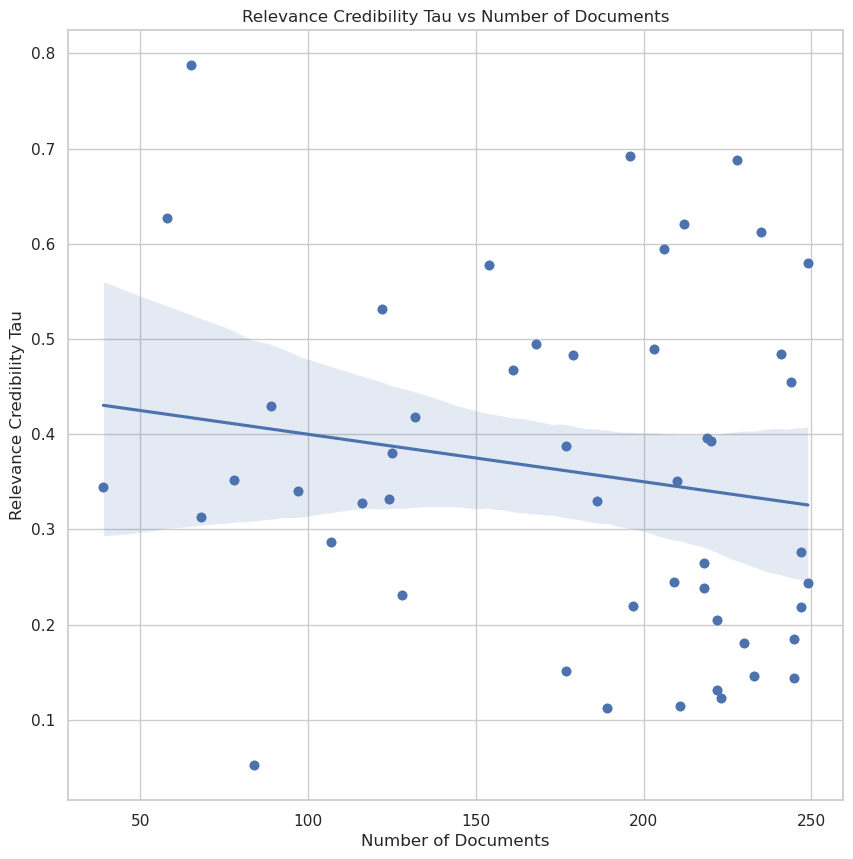

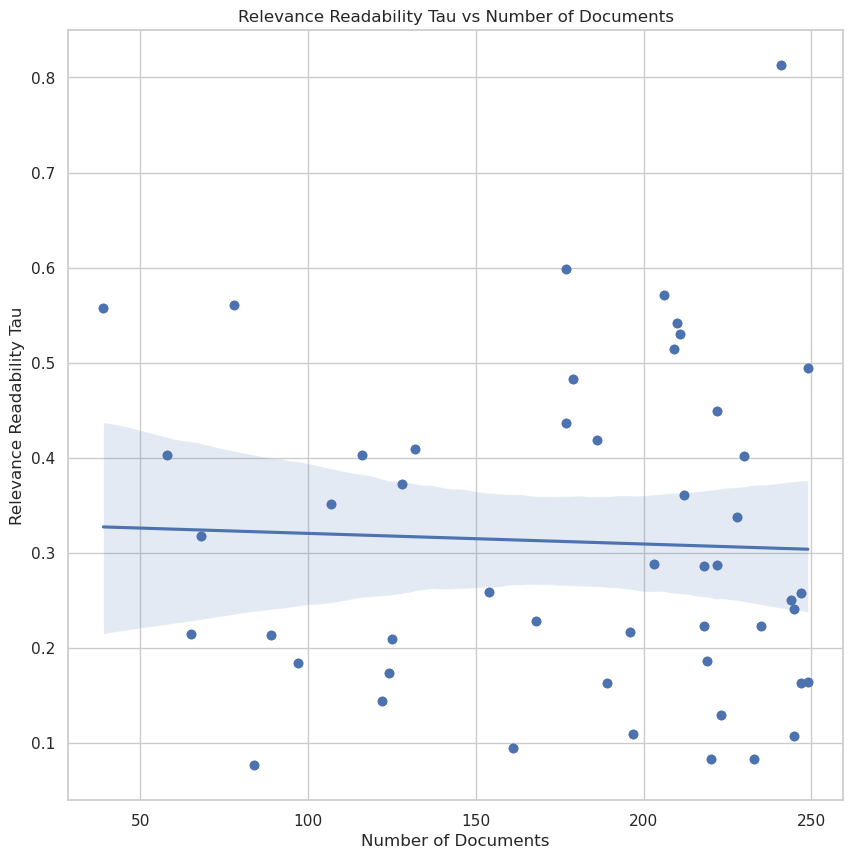

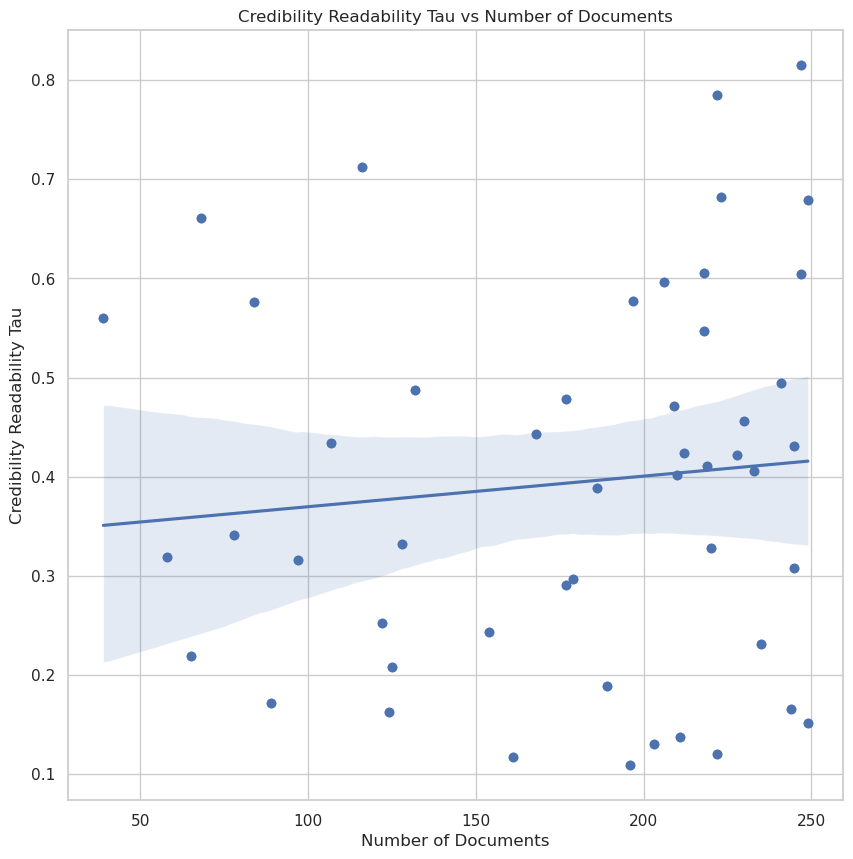

In [121]:
# check for relation between number of docs and tau values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# include line of best fit
def plot_tau_vs_number_of_docs(tau_list, number_of_docs_list, tau_name):
    plt.figure(figsize=(10, 10))
    sns.regplot(x=number_of_docs_list, y=tau_list)
    plt.scatter(number_of_docs_list, tau_list)
    plt.xlabel("Number of Documents")
    plt.ylabel(tau_name)
    plt.title(f"{tau_name} vs Number of Documents")
    plt.show()

plot_tau_vs_number_of_docs(relevant_docs_df["rel_cred_tau"], relevant_docs_df["number_of_docs"], "Relevance Credibility Tau")
plot_tau_vs_number_of_docs(relevant_docs_df["rel_read_tau"], relevant_docs_df["number_of_docs"], "Relevance Readability Tau")
plot_tau_vs_number_of_docs(relevant_docs_df["cred_read_tau"], relevant_docs_df["number_of_docs"], "Credibility Readability Tau")

In [122]:
# get query text from queries dataframe
def get_query_text(qid):
    return all_queries_df[all_queries_df["qid"] == qid]["query"].values[0]

get_query_text("1")

'What are the most common chronic diseases? What effects do chronic diseases have for the society and the individual?'

In [123]:


# print out the queries with the highest and lowest tau values
def print_queries_with_highest_and_lowest_tau(tau_list, number_of_docs_list, tau_name, queries, n):
    # sort by tau value
    tau_list, number_of_docs_list, queries = zip(*sorted(zip(tau_list, number_of_docs_list, queries), reverse=True))
    print(f"Queries with highest {tau_name}")
    for i in range(n):
        print(f"Query {queries[i]}: {tau_name} {tau_list[i]}, number of docs {number_of_docs_list[i]}")
        print(f"Query text: {get_query_text(queries[i])}")
        print()
    print("*"*50)
    print(f"Queries with lowest {tau_name}")
    for i in range(n):
        print(f"Query {queries[-i-1]}: {tau_name} {tau_list[-i-1]}, number of docs {number_of_docs_list[-i-1]}")
        print(f"Query text: {get_query_text(queries[-i-1])}")
        print() 

print_queries_with_highest_and_lowest_tau(relevant_docs_df["rel_cred_tau"], relevant_docs_df["number_of_docs"], "Relevance Credibility Tau", relevant_docs_df["qid"], 5)

Queries with highest Relevance Credibility Tau
Query 127: Relevance Credibility Tau 0.7875, number of docs 65
Query text: glasses for computer

Query 85: Relevance Credibility Tau 0.6923076923076924, number of docs 196
Query text: Relapsing remitting multiple sclerosis

Query 79: Relevance Credibility Tau 0.6881520983074425, number of docs 228
Query text: Can I pass multiple sclerosis to other family members?

Query 108: Relevance Credibility Tau 0.6273442226255292, number of docs 58
Query text: chronic diarrhea short-term memory sweating inability to regulate body temperature heart palpitations dysautonomia

Query 72: Relevance Credibility Tau 0.6211213448985068, number of docs 212
Query text: Is the Covid-19 vaccine safe for people taking multiple sclerosis drugs?

**************************************************
Queries with lowest Relevance Credibility Tau
Query 131: Relevance Credibility Tau 0.052208835341365466, number of docs 84
Query text: exercises for better posture

Query 

In [124]:
passages_with_qrels = pd.merge(all_passages, qrels, left_on="docid", right_on="docno")

In [125]:
passages_with_qread = pd.merge(all_passages, qread, left_on="docid", right_on="docno")

In [126]:
passages_with_qcred = pd.merge(all_passages, qcred, left_on="docid", right_on="docno")

In [127]:
passages_with_qcred.head()

,docid,text,qid,docno,label
0,44f906a1-f818-4d48-a3fb-1673ebdeff13,Billing & Financial Services Patients & Visito...,63,44f906a1-f818-4d48-a3fb-1673ebdeff13,2
1,44f906a1-f818-4d48-a3fb-1673ebdeff13,Billing & Financial Services Patients & Visito...,93,44f906a1-f818-4d48-a3fb-1673ebdeff13,1
2,44f906a1-f818-4d48-a3fb-1673ebdeff13,Billing & Financial Services Patients & Visito...,94,44f906a1-f818-4d48-a3fb-1673ebdeff13,0
3,334ed241-6337-41ce-884c-2755648e14ea,Billing & Financial Services Patients & Visito...,123,334ed241-6337-41ce-884c-2755648e14ea,1
4,391b9de2-26dc-4187-b7ea-461153352e12,Billing & Financial Services Patients & Visito...,93,391b9de2-26dc-4187-b7ea-461153352e12,2


In [128]:
# merge qrels, qcred, qread to one dataframe with columns qid, uuid, qrel, qcred, qread
qmerge = qrels.merge(qcred, on=["qid", "docno"], how="left")
qmerge = qmerge.merge(qread, on=["qid", "docno"], how="left")
qmerge = qmerge.rename(columns={"docno": "uuid", "label_x": "qrel", "label_y": "qcred", "label": "qread"})

In [129]:
# filter qmerge for uuids which are in all_passages
qmerge = qmerge[qmerge.uuid.isin(all_passages.docid)]

In [130]:
qmerge.head()

,qid,uuid,qrel,qcred,qread
0,1,a6195d99-f7d7-43ec-907c-435cb7a62ee7,2,2,2
1,1,80fd9af1-c9b6-4d82-b62a-fe16d5b9d76f,1,1,1
2,1,4a8c5d85-b2d0-43bc-83f4-c1acfe0b3481,2,2,2
3,1,22990a4b-6a9f-4e00-9e72-aef0fbee202b,0,2,2
4,1,fd6ddab2-e4d9-4151-9972-256f5be6eb21,1,2,2


In [131]:
# get number of unique uuids
print(len(qmerge.uuid.unique()))
# get all duplicate uuids and print them, incuding the number of duplicates and the values in the columns as list
duplicates = qmerge[qmerge.uuid.duplicated(keep=False)].groupby("uuid").agg({"uuid": "count", "qrel": list, "qcred": list, "qread": list, "qid": list}).rename(columns={"uuid": "count"}).sort_values("count", ascending=False)

# visualize duplicates
duplicates.head()
print(len(duplicates))

print("total number of uuids ", len(qmerge))

6692
875
total number of uuids  8902


In [132]:
duplicates.head()

,count,qrel,qcred,qread,qid
uuid,,,,,
ec97f55f-12fd-4b1b-ba89-32e5ec77f28f,18,"[2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 1, 1, 2, 2, 1, ...","[2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[54, 55, 57, 58, 59, 63, 68, 72, 77, 79, 81, 8..."
fc1fd012-c7d3-4ed2-ae3b-ed795426759c,17,"[2, 2, 2, 1, 2, 1, 0, 0, 0, 1, 2, 1, 1, 1, 1, ...","[2, 2, 2, 1, 1, 2, 1, 3, 1, 2, 1, 1, 3, 2, 1, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, ...","[54, 55, 57, 58, 63, 68, 72, 77, 79, 81, 83, 8..."
401363ff-141a-4cc9-8b47-484a277e102f,16,"[2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 2, 1, 2, 0]","[2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2]","[2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 0]","[54, 55, 57, 58, 59, 63, 68, 77, 79, 81, 83, 8..."
d357d189-6cfd-41eb-85ed-a89de43886a3,15,"[2, 2, 2, 1, 2, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]","[2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 2, 2]","[54, 55, 57, 58, 59, 68, 72, 77, 81, 83, 85, 8..."
feec527f-e1da-49d7-8b1b-088e94ec18ac,14,"[1, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 2, 1, 0]","[2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 0, 0]","[2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 0]","[54, 55, 57, 58, 59, 63, 68, 79, 81, 83, 85, 9..."


In [140]:
# plot first duplicate uuid and compare the values of qrel, qcred, qread using a seaborn heatmap
import seaborn as sns
import matplotlib.pyplot as plt

dup = duplicates.iloc[1]
# expand the lists in the columns to columns
dup = dup.apply(pd.Series).T
dup

,count,qrel,qcred,qread,qid
0,17.0,2,2,2,54
1,NaN,2,2,2,55
2,NaN,2,2,2,57
3,NaN,1,1,2,58
4,NaN,2,1,2,63
5,NaN,1,2,2,68
6,NaN,0,1,2,72
7,NaN,0,3,2,77
8,NaN,0,1,2,79
9,NaN,1,2,2,81


In [146]:
# add column to duplicates with cred_diff and read_diff, containing the maximum difference between the values in the list
duplicates["cred_diff"] = duplicates["qcred"].apply(lambda x: max(x) - min(x))
duplicates["read_diff"] = duplicates["qread"].apply(lambda x: max(x) - min(x))
# get duplicates with cred_diff == 0 and read_diff == 0
duplicates[(duplicates["cred_diff"] == 0) & (duplicates["read_diff"] == 0)]

,count,qrel,qcred,qread,qid,cred_diff,read_diff
uuid,,,,,,,
6e125cf4-1af5-42e5-9d00-a311c55b14fa,4,"[2, 1, 2, 0]","[2, 2, 2, 2]","[2, 2, 2, 2]","[54, 59, 63, 68]",0,0
e4a23a3b-69bf-4cf4-a961-75e8d2e80a0b,3,"[0, 0, 0]","[1, 1, 1]","[2, 2, 2]","[8, 22, 35]",0,0
0921940c-6f62-44dd-acff-de0a1de8e440,3,"[2, 0, 2]","[2, 2, 2]","[2, 2, 2]","[63, 68, 94]",0,0
2258d513-5683-4ec8-9a17-788c09f914a1,3,"[1, 1, 1]","[2, 2, 2]","[2, 2, 2]","[54, 55, 57]",0,0
0cc19231-afa8-4a9c-b85d-c345da70b899,3,"[0, 0, 1]","[1, 1, 1]","[1, 1, 1]","[83, 85, 86]",0,0
...,...,...,...,...,...,...,...
249144d5-216d-4ffe-ae9b-32656f4c4530,2,"[0, 0]","[0, 0]","[1, 1]","[8, 35]",0,0
962f5662-6a90-400a-ba79-d6e17d7ad370,2,"[0, 0]","[1, 1]","[1, 1]","[8, 35]",0,0
954348dd-f5f3-4a36-b3a2-cceb6944efc6,2,"[0, 0]","[1, 1]","[2, 2]","[8, 35]",0,0


In [149]:
# get duplicates with diffs higher than 0 and calculate the mean of the diffs
duplicates[(duplicates["cred_diff"] > 0) & (duplicates["read_diff"] > 0)].mean()

/tmp/ipykernel_7526/4078721882.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  duplicates[(duplicates["cred_diff"] > 0) & (duplicates["read_diff"] > 0)].mean()


count        4.498812
cred_diff    1.451306
read_diff    1.232779
dtype: float64

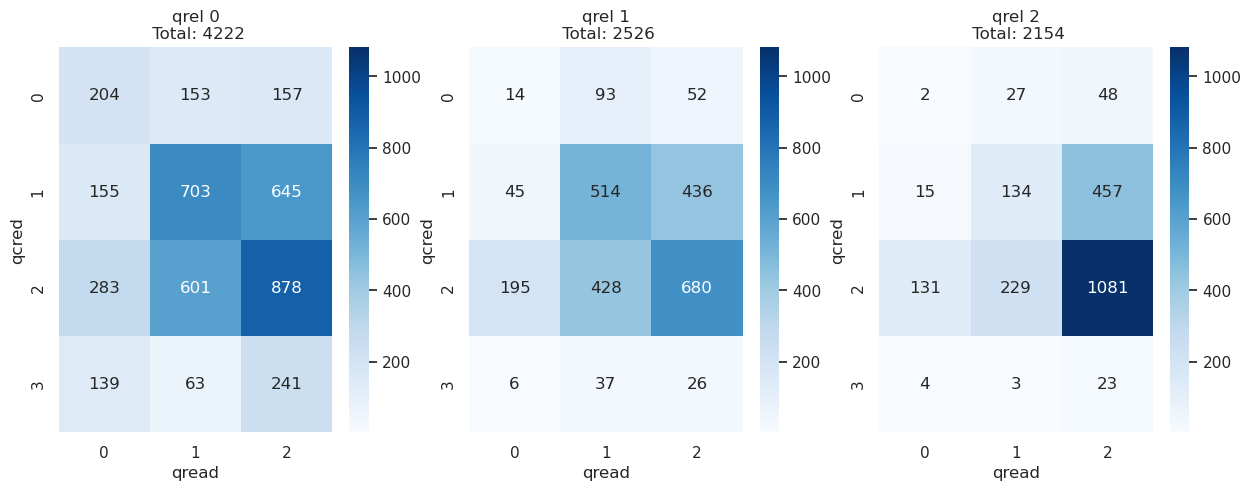

In [134]:
# generate separate heatmap for qrel 0,1 and 2, showing qcred and qread on the x and y axis. Usa a nice color scheme and annotate the cells with the number of passages in each cell.

import seaborn as sns
import matplotlib.pyplot as plt

qmerge["qrel"] = qmerge["qrel"].astype(int)
qmerge["qcred"] = qmerge["qcred"].astype(int)
qmerge["qread"] = qmerge["qread"].astype(int)

# generate 3 heatmaps next to each other
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# heatmap for qrels. colormap should have same intensity for all qrels
cmap = sns.color_palette("Blues", as_cmap=True)
vmin = qmerge.groupby(["qrel", "qcred", "qread"]).size().min()
vmax = qmerge.groupby(["qrel", "qcred", "qread"]).size().max()
for rel in [0,1,2]:
    qrel = qmerge[qmerge.qrel == rel]
    sns.heatmap(qrel.groupby(["qcred", "qread"]).size().unstack(), annot=True, fmt="d", ax=axes[rel], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[rel].set_title(f"qrel {rel}" + "\n Total: " + str(len(qrel)))


In [141]:
def get_text_from_uuid(uuid):
    return all_passages[all_passages.docid == uuid].text.values[0]

def get_query_from_qid(qid):
    return all_queries_df[all_queries_df.qid == qid]['query'].values[0]

get_text_from_uuid("fc1fd012-c7d3-4ed2-ae3b-ed795426759c")

'StudyMode - Premium and Free Essays, Term Papers & Book Notes Home Essays Multiple Sclerosis , , Dietitians and Multiple Sclerosis Ryan Herndon Kaplan University Professor Seeman June 26, 2012 Multiple Sclerosis (M.S.) is an autoimmune disease that affects the brain and spinal cord (PubMed Health, 2012). Approximately 250,000 to 350,000 people have been diagnosed with M.S. in the United States (Schoenstadt, 2006). Every week, 200 new people are diagnosed with M.S. in our country (National MS Society, n.d.). M.S. can affect each person differently. Damage to the myelin in the Central Nervous System and nerve fibers disturb the signals sent between the brain and spinal cord to other parts of the body causing the primary symptoms of Multiple Sclerosis (National MS Society, n.d.)Symptoms can come and go without any warning. An idea on how to help people suffering from M.S. is to have a dietitian either come to an M.S. housing building or support group, and introduce a healthy, nutritious 

In [142]:
for qid in list(dup['qid'].values):
    print(get_query_from_qid(str(qid)))

What does multiple sclerosis diagnosis include? What does it change?
How to manage multiple sclerosis?
multiple sclerosis stages phases
Risk to develop multiple sclerosis
Will multiple sclerosis affect my career?
List of multiple sclerosis symptoms
Is the Covid-19 vaccine safe for people taking multiple sclerosis drugs?
How do menopause symptoms relate to multiple sclerosis symptoms?
Can I pass multiple sclerosis to other family members?
Can I work and study full-time with multiple sclerosis?
Why get episode diagnosed by a doctor as a relapse of multiple sclerosis?
Relapsing remitting multiple sclerosis
Secondary progressive multiple sclerosis
causes of fatigue in MS
Does multiple sclerosis relate to sleeping problems and forgetfulness in older people?
When will I start to feel better with multiple sclerosis?
Reading problems in MS


In [137]:
# new df with cols qid, qrel_0, qrel_1, qrel_2, qcred_0, qcred_1, qcred_2, qread_0, qread_1, qread_2
# uuid is dropped, qrel_0 contains the number of uuids with qrel=0 for each qid
qagg = qmerge.groupby(["qid"]).agg({"qrel": [lambda x: (x==0).sum(), lambda x: (x==1).sum(), lambda x: (x==2).sum()],
                                        "qcred": [lambda x: (x==0).sum(), lambda x: (x==1).sum(), lambda x: (x==2).sum(), lambda x: (x==3).sum()],
                                        "qread": [lambda x: (x==0).sum(), lambda x: (x==1).sum(), lambda x: (x==2).sum()],
                                        "uuid": "count"})
qagg.columns = ["qrel_0", "qrel_1", "qrel_2", "qcred_0", "qcred_1", "qcred_2", "qcred_3", "qread_0", "qread_1", "qread_2", "uuid_count"]
qagg = qagg.reset_index()
# order dataframe by qid, qid as integer
qagg = qagg.sort_values(by=["qid"], key=lambda x: x.astype(int))

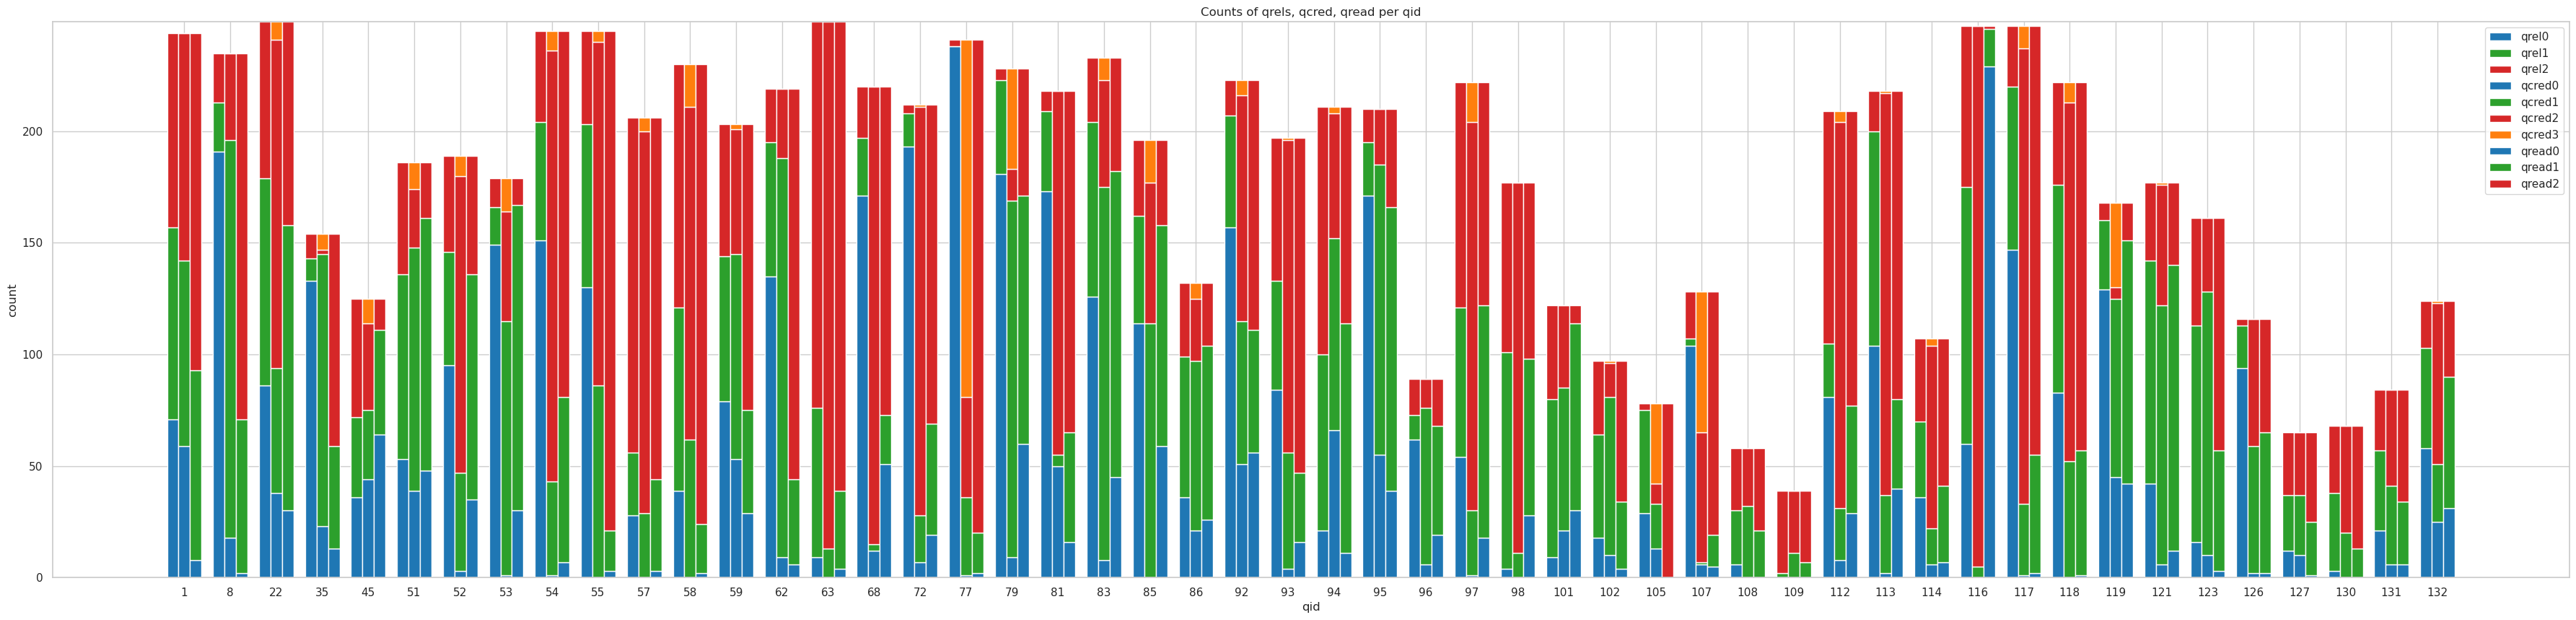

In [138]:
# visualize the table as a bar chart. qrels, qcred, qread are plotted in separate bars, to in total 3 bars per qid.
# The different values (qrel_0, qrel_1, qrel2) of qrels, qcred, qread are stacked on top of each other.
import numpy as np
import matplotlib.pyplot as plt

# increase figure size
plt.rcParams['figure.figsize'] = [45, 10]

fig, ax = plt.subplots()
# set width of bar
width = 0.25

# 4 colors blue green red yellow
colors = ["#1f77b4", "#2ca02c", "#d62728", "#ff7f0e"]

bottom = np.zeros(50)

weight_counts_qrels = {
    "qrel0": qagg.qrel_0,
    "qrel1": qagg.qrel_1,
    "qrel2": qagg.qrel_2
}

weight_counts_qcred = {
    "qcred0": qagg.qcred_0,
    "qcred1": qagg.qcred_1,
    "qcred2": qagg.qcred_2,
    "qcred3": qagg.qcred_3
}
weight_counts_qread = {
    "qread0": qagg.qread_0,
    "qread1": qagg.qread_1,
    "qread2": qagg.qread_2
}

all_weight_counts = [weight_counts_qrels, weight_counts_qcred, weight_counts_qread]

x = np.arange(50)
for idx, all_weight in enumerate(all_weight_counts):
    bottom = np.zeros(50)
    color_index = 0
    for boolean, weight_count in all_weight.items():
        p = ax.bar(x + idx*0.25, weight_count, width, label=boolean, bottom=bottom, color=colors[color_index])
        bottom += weight_count
        color_index += 1

# Add some text for labels, title and custom x-axis tick labels, etc.

plt.xlabel('qid')
plt.ylabel('count')
plt.title('Counts of qrels, qcred, qread per qid')
plt.xticks(x + width, qagg.qid)
# Create legend & Show graphic
plt.legend()
plt.show()
